In [1]:
import datetime
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from emoji import get_emoji_regexp
from functools import reduce
from nltk.sentiment import SentimentIntensityAnalyzer
from random import shuffle
from sklearn import preprocessing
from time import strptime
from wordcloud import WordCloud, STOPWORDS

# Import data
reddit = pd.read_csv('./Datasets/reddit_wsb.csv')

# Data cleaning functions
emoji_pattern = get_emoji_regexp()

def remove_emojis(text):
    return re.sub(emoji_pattern, '', text)

def remove_punctuations(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def remove_tags(text):
    return re.sub('@[\w]*', '', text)

def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

# Applies a list of functions to a dataframe and returns the resultant dataframe
def data_cleaning(df, func_list):
    result = df.copy()
    for f in func_list:
        result = result.apply(f)
    return result

# List of data cleaning functions
cleaning_func = [(lambda x : remove_emojis(x)), (lambda x: x.lower()), (lambda x: remove_URLs(x)), 
                 (lambda x: remove_tags(x)), (lambda x: remove_punctuations(x)), (lambda x: x.strip())]

# Change Timestamp to date format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp']).dt.date
reddit.rename(columns = {'timestamp': 'date'}, inplace = True)

# Removes any rows with dates outside of 2021
reddit = reddit[reddit['date'] >= datetime.date(2021, 1, 1)]

# Extract out relevant data - the date, thread title and body only
reddit_title = reddit[['date', 'title']].copy()
reddit_body = reddit[['date', 'body']].copy()

# Data Cleaning
reddit_title['title'] = data_cleaning(reddit_title['title'], cleaning_func)
reddit_body = reddit_body[reddit_body['body'].notna()] # removes NaN values
reddit_body['body'] = data_cleaning(reddit_body['body'], cleaning_func)

# Removes rows with empty strings
reddit_title = reddit_title[reddit_title['title'] != '']
reddit_body = reddit_body[reddit_body['body'] != '']

# Resets row index
reddit_title = reddit_title.reset_index(drop = True)
reddit_body = reddit_body.reset_index(drop = True)

In [2]:
reddit_title.head()

,date,title
0,2021-01-28,its not about the money its about sending a me...
1,2021-01-28,math professor scott steiner says the numbers ...
2,2021-01-28,exit the system
3,2021-01-28,new sec filing for gme can someone less retard...
4,2021-01-28,not to distract from gme just thought our amc ...


In [3]:
reddit_body.head()

,date,body
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...
1,2021-01-28,hedgefund whales are spreading disinfo saying ...
2,2021-01-28,life isnt fair my mother always told me that w...
3,2021-01-28,i believe right now is one of those rare oppor...
4,2021-01-28,you guys are champs gme who would have thought...


In [4]:
# Conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

def addSentimentAnalysis(df, columnName):
    # Creates new column in the input dataframe
    columns = {col: 0 for col in ['negative', 'neutral', 'positive', 'compound', 'sentiment']}
    df.assign(**columns)
    
    for i in range(len(df.index)):
        sentence = df[columnName][i]
        scores = sia.polarity_scores(sentence)

        df.loc[i, 'negative'] = scores.get('neg')
        df.loc[i, 'positive'] = scores.get('pos')
        df.loc[i, 'neutral'] = scores.get('neu')
        df.loc[i, 'compound'] = scores.get('compound')

        if scores.get('compound') > 0: 
            df.loc[i, 'sentiment'] = 1
        elif scores.get('compound') == 0: 
            df.loc[i, 'sentiment'] = 0
        else: 
            df.loc[i, 'sentiment'] = -1

addSentimentAnalysis(reddit_title, 'title')
addSentimentAnalysis(reddit_body, 'body')

In [5]:
reddit_title.head()

,date,title,negative,positive,neutral,compound,sentiment
0,2021-01-28,its not about the money its about sending a me...,0.000,0.000,1.000,0.0000,0.0
1,2021-01-28,math professor scott steiner says the numbers ...,0.272,0.000,0.728,-0.6249,-1.0
2,2021-01-28,exit the system,0.000,0.000,1.000,0.0000,0.0
3,2021-01-28,new sec filing for gme can someone less retard...,0.204,0.138,0.658,-0.2748,-1.0
4,2021-01-28,not to distract from gme just thought our amc ...,0.000,0.119,0.881,0.2235,1.0


In [6]:
reddit_body.head()

,date,body,negative,positive,neutral,compound,sentiment
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...,0.054,0.084,0.862,0.7854,1.0
1,2021-01-28,hedgefund whales are spreading disinfo saying ...,0.000,0.056,0.944,0.7784,1.0
2,2021-01-28,life isnt fair my mother always told me that w...,0.172,0.068,0.760,-0.9927,-1.0
3,2021-01-28,i believe right now is one of those rare oppor...,0.082,0.153,0.765,0.8271,1.0
4,2021-01-28,you guys are champs gme who would have thought...,0.068,0.120,0.812,0.9384,1.0


In [7]:
# Creates a dataframe with average sentiments grouped by dates
def filter_df(df, columnName, strToFilter):
    suffix = re.sub('\|.+', '', strToFilter)
    rdf = (df[df[columnName].str.contains(r'\b{0}\b'.format(strToFilter))].groupby('date')
                                                                          .agg({'negative': ['count', ('negative_mean', 'mean')],
                                                                                'positive': [('positive_mean', 'mean')],
                                                                                'neutral': [('neutral_mean', 'mean')],
                                                                                'compound': [('compound_mean', 'mean')]})
                                                                          .add_suffix('' if not suffix else '_' + suffix)
                                                                          .reset_index())
    
    rdf.columns = rdf.columns.droplevel(0)
    rdf = rdf.rename(columns = {'':'date'})
    return (rdf)

# Strings to filter the dataframe
amc_words = 'amc'
bb_words = 'bb|blackberry|black berry'
clov_words = 'clov|clover'
gme_words = 'gme|gamestop|game stop|gamestonks'
#nok_words = 'nok|nokia'

# Filtering dataframe by individual stock ticker symbols
# Thread title
amc_title = filter_df(reddit_title, 'title', amc_words)
bb_title = filter_df(reddit_title, 'title', bb_words)
clov_title = filter_df(reddit_title, 'title', clov_words)
gme_title = filter_df(reddit_title, 'title', gme_words)
#nok_title = filter_df(reddit_title, 'title', nok_words)

# Thread body
amc_body = filter_df(reddit_body, 'body', amc_words)
bb_body = filter_df(reddit_body, 'body', bb_words)
clov_body = filter_df(reddit_body, 'body', clov_words)
gme_body = filter_df(reddit_body, 'body', gme_words)
#nok_body = filter_df(reddit_body, 'body', nok_words)

# Main dataframes
reddit_title_daily = filter_df(reddit_title, 'title', '')
reddit_body_daily = filter_df(reddit_body, 'body', '')

# Merging all dataframes
dfs = [reddit_title_daily, reddit_body_daily, gme_title, gme_body, amc_title, amc_body, 
       bb_title, bb_body, clov_title, clov_body]
reddit_wsb_daily = reduce(lambda df1, df2: pd.merge(df1, df2, on = 'date', how = 'left', suffixes = ('_title', '_body')), dfs)

# Export daily aggregated data to csv
reddit_wsb_daily.to_csv("./Datasets/reddit_wsb_daily.csv", index = False)

In [8]:
reddit_wsb_daily.head()

,date,count_title,negative_mean_title,positive_mean_title,neutral_mean_title,compound_mean_title,count_body,negative_mean_body,positive_mean_body,neutral_mean_body,...,count_clov_title,negative_mean_clov_title,positive_mean_clov_title,neutral_mean_clov_title,compound_mean_clov_title,count_clov_body,negative_mean_clov_body,positive_mean_clov_body,neutral_mean_clov_body,compound_mean_clov_body
0,2021-01-28,1192,0.087679,0.078799,0.832689,-0.007051,684,0.089819,0.095503,0.813212,...,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-29,15653,0.086568,0.079090,0.833768,-0.014411,9034,0.089565,0.093308,0.816350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-30,1422,0.077357,0.096356,0.825584,0.036902,648,0.081015,0.115835,0.803154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-31,937,0.077020,0.099076,0.822843,0.039319,426,0.087824,0.115261,0.796904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-01,880,0.074460,0.103527,0.822012,0.037553,319,0.075276,0.114342,0.810364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


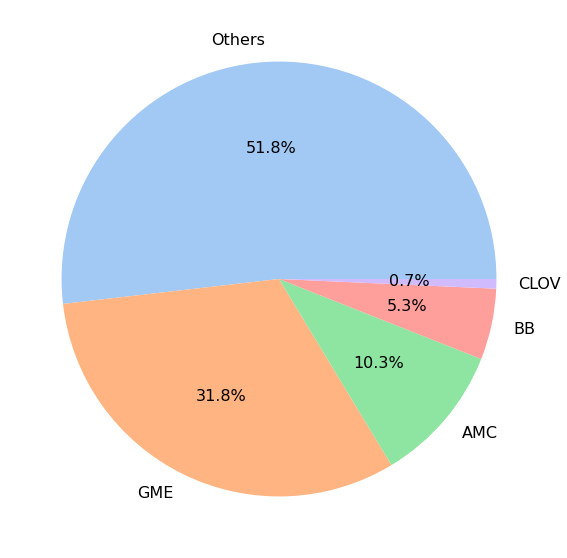

In [9]:
# Get overall count of columns
overall_count = reddit_wsb_daily[['count_body', 'count_gme_body', 'count_amc_body', 'count_bb_body', 'count_clov_body']].sum(axis = 0)

# Get remaining count of non-individual stocks
overall_count[0] -= sum(overall_count[1:5])

# Rename indices
overall_count.rename(index = {'count_body':'Others', 'count_gme_body':'GME', 'count_amc_body':'AMC', 'count_bb_body':'BB',
                              'count_clov_body':'CLOV'}, inplace = True)

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Plot pie chart
plt.figure(figsize = (15,10))
plt.pie(overall_count, labels = overall_count.index, colors = colors, autopct='%1.1f%%', textprops = {'fontsize': 16})
plt.show()

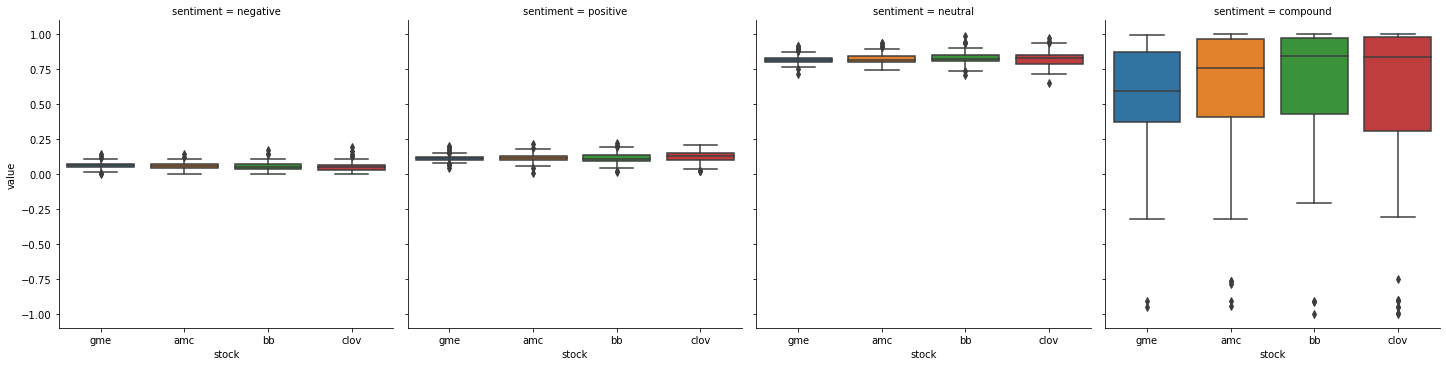

In [10]:
# Get mean thread body sentiment of individual stocks
test = reddit_wsb_daily.iloc[:, np.r_[17:21, 27:31, 37:41, 47:51]]

# Convert dataframe from wide to long format
test_long = test.melt(var_name = 'sentiment')

# Add column to identify stock
test_long['stock'] = test_long['sentiment'].apply(lambda x: re.sub('.+mean_|_body', '', x))

# Clean sentiment column
test_long['sentiment'] = test_long['sentiment'].apply(lambda x: re.sub('_.+', '', x))

# Drop NaN rows
test_long = test_long.dropna(subset = ['value'])

#test_long
sns.catplot(data = test_long, x = 'stock', y = 'value', col = 'sentiment', kind = 'box', col_wrap = 4)

In [12]:
def normalise_df(df, columnNames):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(df[columnNames])
    scaled_df = pd.DataFrame(d, columns = columnNames)
    return scaled_df

# Normalise dataframes
reddit_wsb_daily_norm = normalise_df(reddit_wsb_daily, ['count_title', 'compound_mean_title', 
                                                        'count_body', 'compound_mean_body'])

# Add date columns to dataframes
reddit_wsb_daily_norm.insert(0, 'date', reddit_wsb_daily['date'])

<AxesSubplot:xlabel='date'>

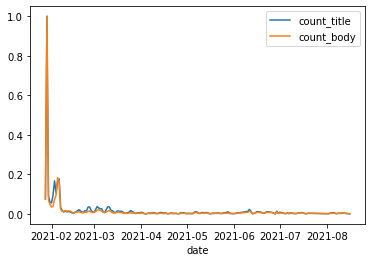

In [13]:
reddit_wsb_daily_norm.plot(x = 'date', y = ['count_title', 'count_body'], kind = 'line')

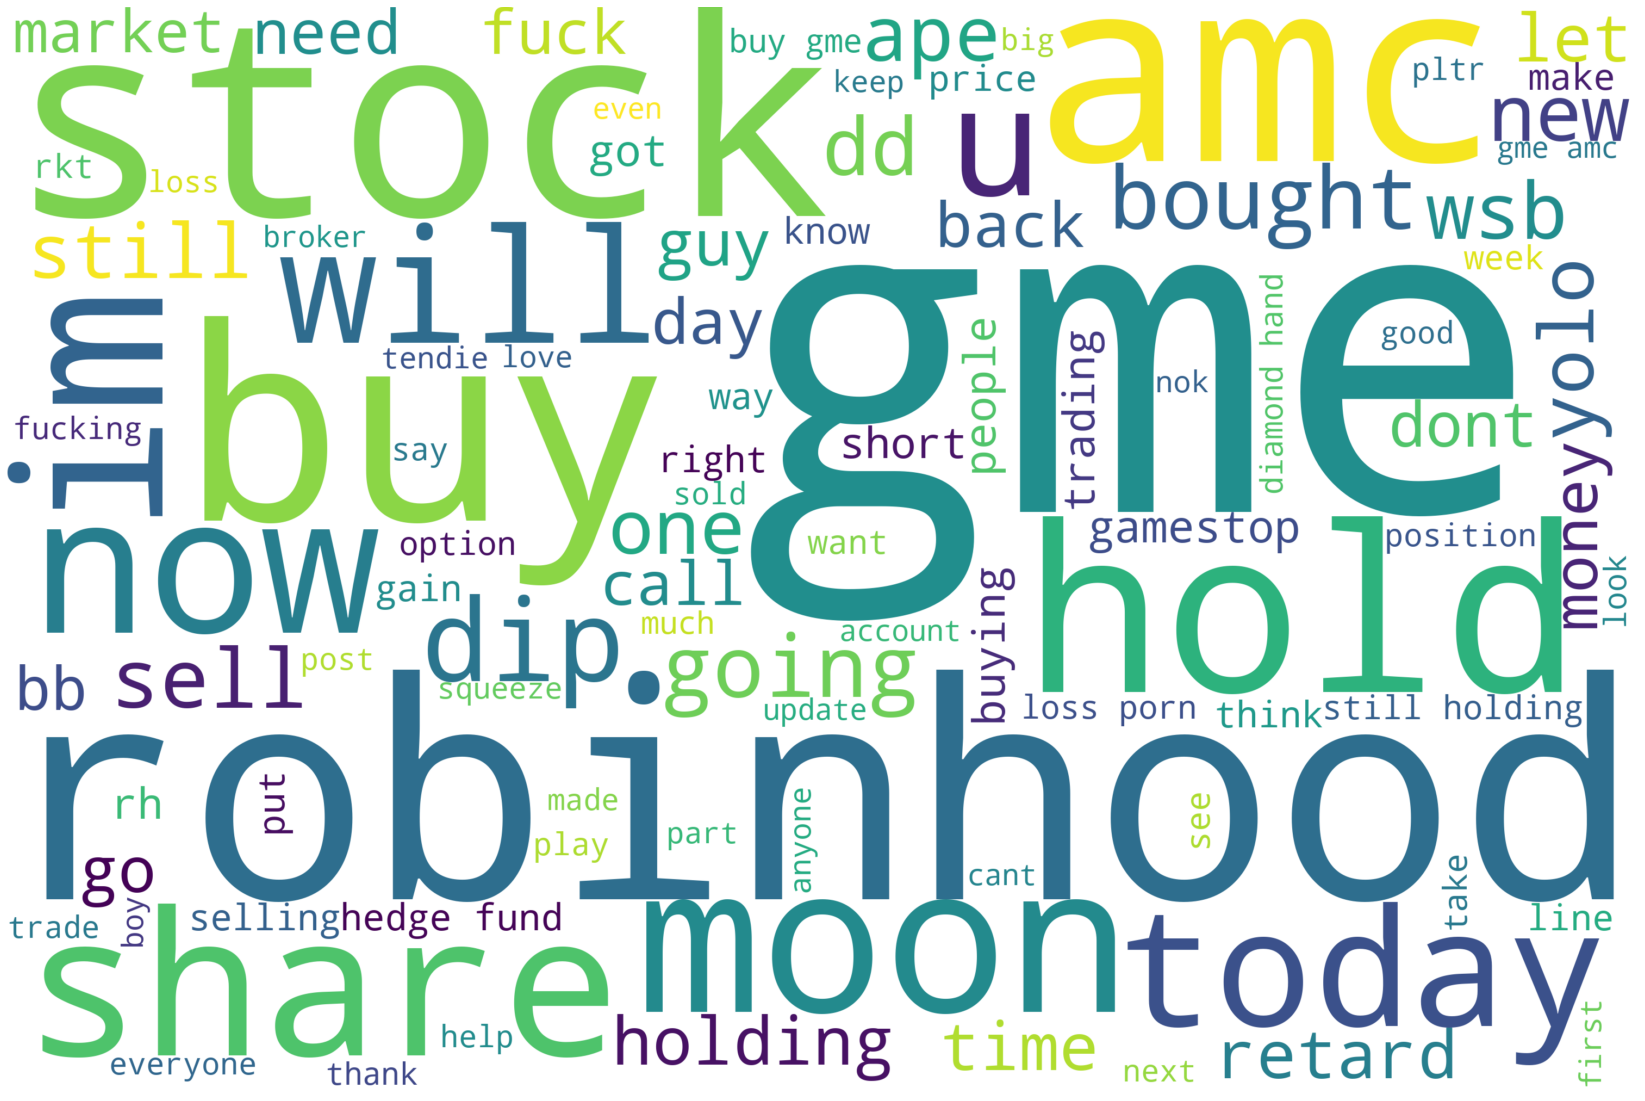

In [14]:
def createWordCloud(text):
    # Generates a word cloud image
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                          max_words = 100, stopwords = STOPWORDS).generate(text)

    # Displays the wordcloud image
    plt.figure(figsize = (30,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

title_text = ' '.join(title for title in reddit_title['title'])
body_text = ' '.join(body for body in reddit_body['body'])

createWordCloud(title_text)

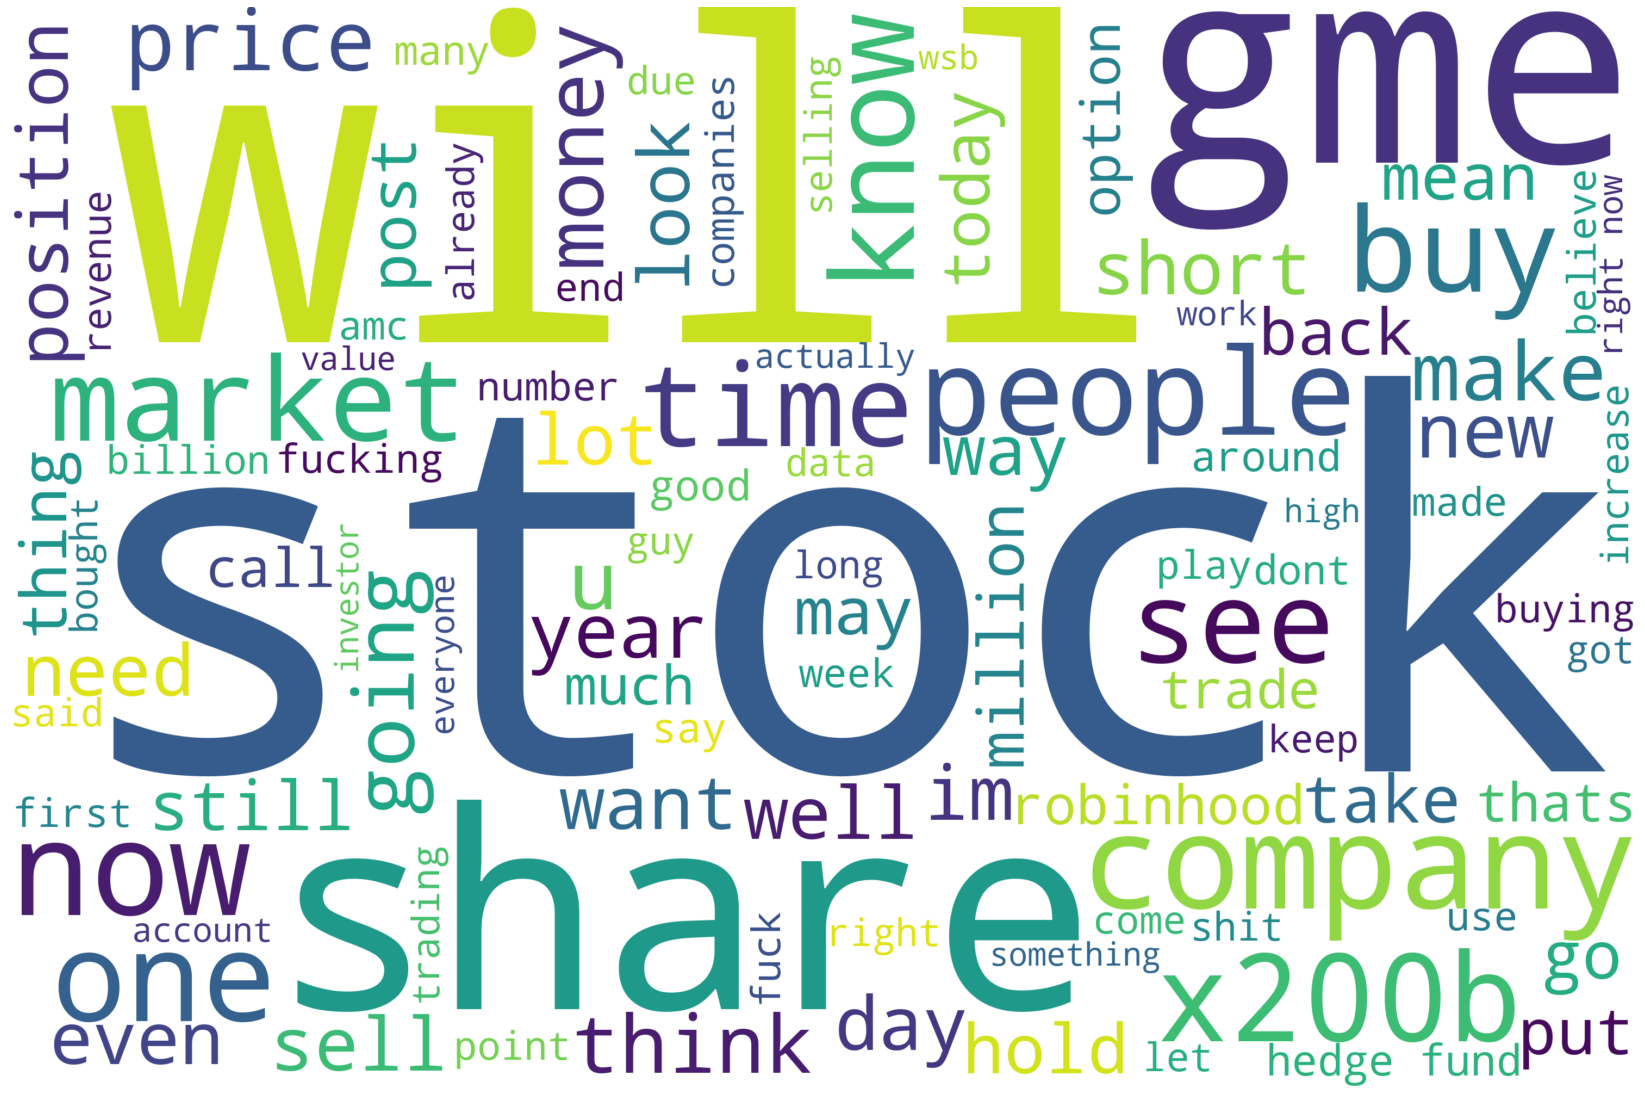

In [15]:
createWordCloud(body_text)